### Variational Autoencoder. 

In [13]:
import os

import numpy as np
import torch
import torch.nn.functional as F
import torchvision as tv

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


### Load MNIST dataset.

In [14]:
transform = tv.transforms.Compose([tv.transforms.ToTensor()])
#transform = tv.transforms.Compose([tv.transforms.ToTensor(),
#                                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

datasets = {
    'train': tv.datasets.MNIST(os.path.join('mnist', 'train'), 
                               train=True, 
                               download=True, 
                               transform=transform),
    'test': tv.datasets.MNIST(os.path.join('mnist', 'test'), 
                              train=False, 
                              download=True, 
                              transform=transform),    
}

dataloaders = {
    name: torch.utils.data.DataLoader(value, batch_size=100, shuffle=True) for name, value in datasets.items()
}    


In [15]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, .5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

torch.Size([100, 1, 28, 28])

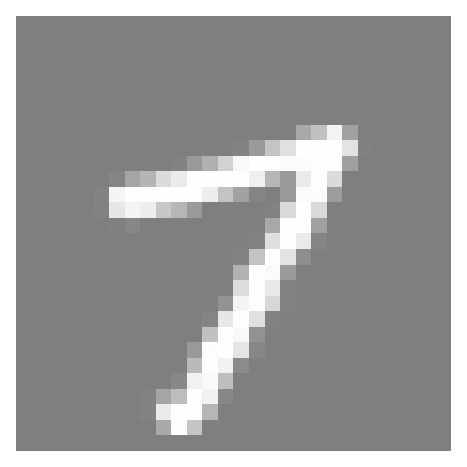

In [16]:
image, label = next(iter(dataloaders['train']))
imshow(image[0])
image.shape

#### Define model for training Variational Auto Encoder.

In [17]:
class Model(torch.nn.Module):
    def __init__(self, input_size, code_size, hidden_size):
        super(Model, self).__init__()
        self.code_size = code_size
        self.input_size = input_size
        self.encoder_fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc_mu = torch.nn.Linear(hidden_size, code_size)
        self.fc_logvar = torch.nn.Linear(hidden_size, code_size)
        
        self.decoder_fc1 = torch.nn.Linear(code_size, hidden_size)
        self.decoder_fc2 = torch.nn.Linear(hidden_size, input_size)


    def encode(self, x):
        h = F.relu(self.encoder_fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def decode(self, z):
        h = F.relu(self.decoder_fc1(z))
        return torch.sigmoid(self.decoder_fc2(h))

    def reparam(self, mu, logvar):
        if self.training:
            sigma = torch.exp(0.5*logvar)
            e = torch.randn_like(sigma)
            return e.mul(sigma).add_(mu)
        else:
            return mu
        
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_size))
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar
    
    def infer(self, x):
        """ Return q(z|x)
        """
        self.eval()
        with torch.no_grad():
            mu, logvar = self.encode(x.view(-1, self.input_size))
            return self.reparam(mu, logvar)
            


In [18]:
# Loss function
def vae_loss(x_hat, x, mu, log_variance):
    """ Return value of lower bound of log likelihood.
    """
    batch_size, x_size = x_hat.shape
    bce = F.binary_cross_entropy(x_hat, x.view(-1, 784))
##    mse = torch.nn.MSELoss(size_average=True)(x_hat, x.view(-1, x_size))

    divergence = -0.5 * torch.sum(1. + log_variance - mu.pow(2) - log_variance.exp())
    divergence /= (batch_size * x_size)
    print("BCE={} DL={}".format(bce, divergence))
    return bce + divergence
    

In [19]:
N = 28*28
model = Model(N, 2, 500)

lr = 0.001
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)

train_loss = []
for x, y in iter(dataloaders['train']):
    model.train()
#    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    x_hat, mu, logvar = model(x)
    loss = vae_loss(x_hat, x, mu, logvar)
    
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    print("Loss={}".format(loss.item()))
##    print ("y_hat: {}".format(y_hat.shape))
##    im= y_hat.detach().numpy()
##    im.resize(x.shape[0], 1, 28, 28)
##    imshow(torch.Tensor(im[0]))
##    break


BCE=0.7077926993370056 DL=6.609235242649447e-06
Loss=0.7077993154525757
BCE=0.6568065881729126 DL=0.00013193636550568044
Loss=0.6569385528564453
BCE=0.6129285097122192 DL=0.0002764917444437742
Loss=0.6132050156593323
BCE=0.5641500949859619 DL=0.0005442933761514723
Loss=0.5646944046020508
BCE=0.522943913936615 DL=0.0010490682907402515
Loss=0.5239929556846619
BCE=0.46947842836380005 DL=0.0020466509740799665
Loss=0.47152507305145264
BCE=0.4188874065876007 DL=0.0032841027714312077
Loss=0.4221715033054352
BCE=0.38693350553512573 DL=0.0060994927771389484
Loss=0.3930329978466034
BCE=0.32768407464027405 DL=0.008114022202789783
Loss=0.33579808473587036
BCE=0.3344417214393616 DL=0.012056834995746613
Loss=0.3464985489845276
BCE=0.32080891728401184 DL=0.014377999119460583
Loss=0.3351869285106659
BCE=0.2851044535636902 DL=0.016057517379522324
Loss=0.3011619746685028
BCE=0.3071879744529724 DL=0.017201915383338928
Loss=0.32438987493515015
BCE=0.3027462959289551 DL=0.016937121748924255
Loss=0.31968343

BCE=0.22713038325309753 DL=0.008037179708480835
Loss=0.23516756296157837
BCE=0.23947693407535553 DL=0.0085441367700696
Loss=0.24802106618881226
BCE=0.2314358651638031 DL=0.008265169337391853
Loss=0.2397010326385498
BCE=0.2417440563440323 DL=0.007518798112869263
Loss=0.24926285445690155
BCE=0.22431835532188416 DL=0.00883160624653101
Loss=0.2331499606370926
BCE=0.22886240482330322 DL=0.008332200348377228
Loss=0.23719459772109985
BCE=0.22740720212459564 DL=0.0076182228513062
Loss=0.23502542078495026
BCE=0.2419806569814682 DL=0.00783693976700306
Loss=0.2498175948858261
BCE=0.22521626949310303 DL=0.008333762176334858
Loss=0.233550027012825
BCE=0.23593862354755402 DL=0.007394540589302778
Loss=0.24333316087722778
BCE=0.22792278230190277 DL=0.0073809330351650715
Loss=0.23530371487140656
BCE=0.22421416640281677 DL=0.007752789184451103
Loss=0.23196695744991302
BCE=0.24289067089557648 DL=0.006543878931552172
Loss=0.24943454563617706
BCE=0.2312871217727661 DL=0.0071047162637114525
Loss=0.238391831

Loss=0.21114981174468994
BCE=0.2241298407316208 DL=0.007049446925520897
Loss=0.23117928206920624
BCE=0.21516157686710358 DL=0.0067811040207743645
Loss=0.22194267809391022
BCE=0.23300586640834808 DL=0.00658868532627821
Loss=0.23959454894065857
BCE=0.21661369502544403 DL=0.006653357297182083
Loss=0.22326704859733582
BCE=0.2207806557416916 DL=0.006489000283181667
Loss=0.22726964950561523
BCE=0.21597237884998322 DL=0.006620959844440222
Loss=0.22259333729743958
BCE=0.22015602886676788 DL=0.0068072425201535225
Loss=0.22696326673030853
BCE=0.2261236011981964 DL=0.006724733393639326
Loss=0.23284833133220673
BCE=0.2211938202381134 DL=0.006832215469330549
Loss=0.22802603244781494
BCE=0.21968090534210205 DL=0.006856613792479038
Loss=0.2265375256538391
BCE=0.22347624599933624 DL=0.006980213802307844
Loss=0.23045645654201508
BCE=0.22177498042583466 DL=0.006555572617799044
Loss=0.2283305525779724
BCE=0.20841331779956818 DL=0.006966412533074617
Loss=0.2153797298669815
BCE=0.21094492077827454 DL=0.006

BCE=0.2101416289806366 DL=0.006689839996397495
Loss=0.21683147549629211
BCE=0.22207485139369965 DL=0.0063448501750826836
Loss=0.2284197062253952
BCE=0.22862160205841064 DL=0.006322389468550682
Loss=0.23494398593902588
BCE=0.22754476964473724 DL=0.0059337373822927475
Loss=0.23347850143909454
BCE=0.21951256692409515 DL=0.006514938548207283
Loss=0.2260275036096573
BCE=0.23286673426628113 DL=0.006147988606244326
Loss=0.23901472985744476
BCE=0.21116778254508972 DL=0.006892297882586718
Loss=0.21806007623672485
BCE=0.2258549928665161 DL=0.006132303737103939
Loss=0.23198729753494263
BCE=0.22245070338249207 DL=0.006147383246570826
Loss=0.22859808802604675
BCE=0.2099616527557373 DL=0.00650245975703001
Loss=0.2164641171693802
BCE=0.2184354066848755 DL=0.006066007539629936
Loss=0.22450141608715057
BCE=0.20224371552467346 DL=0.0069322166964411736
Loss=0.2091759294271469
BCE=0.20927204191684723 DL=0.0070333234034478664
Loss=0.21630536019802094
BCE=0.21262912452220917 DL=0.00690281530842185
Loss=0.21

Loss=0.2143280804157257
BCE=0.21618139743804932 DL=0.006228523328900337
Loss=0.2224099189043045
BCE=0.22161754965782166 DL=0.0059347753413021564
Loss=0.22755232453346252
BCE=0.21519580483436584 DL=0.0066213710233569145
Loss=0.22181718051433563
BCE=0.2232072651386261 DL=0.005885099992156029
Loss=0.22909235954284668
BCE=0.21527059376239777 DL=0.006443805061280727
Loss=0.22171439230442047
BCE=0.20510457456111908 DL=0.006744865793734789
Loss=0.21184943616390228
BCE=0.2044619917869568 DL=0.0068434071727097034
Loss=0.2113053947687149
BCE=0.20501115918159485 DL=0.00646519660949707
Loss=0.21147635579109192
BCE=0.21663787961006165 DL=0.0064332508482038975
Loss=0.2230711281299591
BCE=0.21776899695396423 DL=0.006255841348320246
Loss=0.22402483224868774
BCE=0.21945208311080933 DL=0.005839776247739792
Loss=0.22529186308383942
BCE=0.22194904088974 DL=0.005903045181185007
Loss=0.22785209119319916
BCE=0.22100955247879028 DL=0.006038415711373091
Loss=0.22704796493053436
BCE=0.21516364812850952 DL=0.006

BCE=0.21495547890663147 DL=0.006507697980850935
Loss=0.2214631736278534
BCE=0.22058282792568207 DL=0.006663314066827297
Loss=0.22724613547325134
BCE=0.21299056708812714 DL=0.006375697907060385
Loss=0.21936626732349396
BCE=0.20425762236118317 DL=0.006514495704323053
Loss=0.21077211201190948
BCE=0.20437091588974 DL=0.006646879483014345
Loss=0.21101780235767365
BCE=0.2033068835735321 DL=0.006276704370975494
Loss=0.209583580493927
BCE=0.21186095476150513 DL=0.006564060226082802
Loss=0.21842502057552338
BCE=0.20858001708984375 DL=0.005679225083440542
Loss=0.21425923705101013
BCE=0.2066800445318222 DL=0.00642974441871047
Loss=0.2131097912788391
BCE=0.21691475808620453 DL=0.006064428016543388
Loss=0.22297918796539307
BCE=0.22674982249736786 DL=0.006193975917994976
Loss=0.2329438030719757
BCE=0.2108161747455597 DL=0.006644466891884804
Loss=0.21746064722537994
BCE=0.20983055233955383 DL=0.006949722301214933
Loss=0.21678027510643005
BCE=0.1950545758008957 DL=0.006988916080445051
Loss=0.202043488

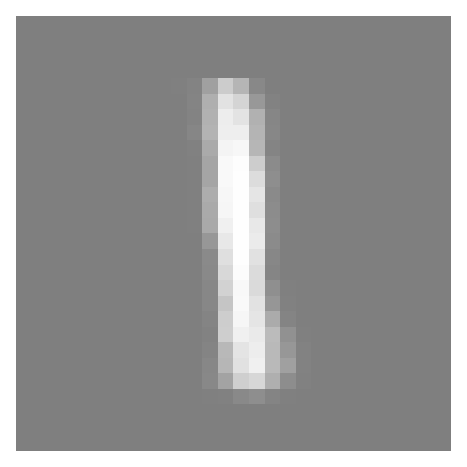

In [20]:
model.eval()
with torch.no_grad():
    for x, y in iter(dataloaders['train']):
        x_hat, _, _ = model.forward(x)
        im = x_hat.detach().numpy()
        im.resize(x_hat.shape[0], 1, 28, 28)
        imshow(torch.Tensor(im[0]))
                  
          # for the first 128 batch of the epoch, show the first 8 input digits
          # with right below them the reconstructed output digits
        n = min(x.size(0), 8)
        comparison = torch.cat([x[:n],
                                  x_hat.view(x.shape[0], 1, 28, 28)[:n]])
        tv.utils.save_image(comparison.data.cpu(),
                     'reconstruction_' + str(1) + '.png', nrow=n)

        break

##### Visualize clustering

In [38]:
def plot_hidden_state(model, dataloader):
    x1 = []
    x2 = []
    label = []
    for x, y in iter(dataloader):
        z = model.infer(x)
        x1.extend(z[:, 0].numpy())
        x2.extend(z[:, 1].numpy())
        label.extend(y)
    plt.scatter(x1, x2, c=label, cmap='tab10')
    plt.colorbar()
    plt.show() 

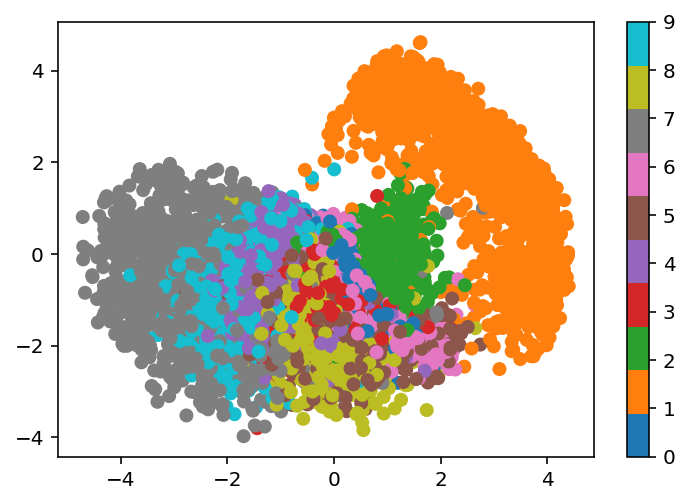

In [39]:
plot_hidden_state(model, dataloaders['test'])